# Simulating Complex Physics with Graph Networks: step by step

## Overview

• By Peng Chen, Shiyu Li, Haochen Shi as part of Stanford CS224W course project. 

• This tutorial provides a step-by-step guide for how to build a Graph Network to simulate complex physics.

**Before we get started:**
- This Colab includes a concise PyG implementation of paper ***Learning to Simulate Complex Physics with Graph Networks*.
- We adapted our code from open-source tensorflow implementation by DeepMind.
    - Link to pdf of this paper: https://arxiv.org/abs/2002.09405
    - Link to Deepmind's implementation: https://github.com/deepmind/deepmind-research/tree/master/learning_to_simulate
    - Link to video site by DeepMind: https://sites.google.com/view/learning-to-simulate
- Run **sequentially run all cells in each section**, so intermediate variables / packages will carry over to next cell.


## Device

We recommend using a GPU for this Colab. Click `Runtime` then `Change runtime type`. Then set `hardware accelerator` to **GPU**.

## Setup

installation of PyG on Colab can be a little bit tricky. Before we get started, let's check which version of PyTorch you are running.

In [1]:
# Dataset Source #1:
# https://drive.google.com/file/d/1ZmiKpsQVLFxPOIff-LfFkZwe5ZYG1FEb/view?usp=drive_link

# Dataset Source #2:
# https://drive.google.com/drive/mobile/folders/11uuYl0peqPg2DQno64YPYMODPu8fjDXU?usp=sharing

In [2]:
#!pip install torch

In [3]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 1.12.1+cu102 with cuda 10.2


• Download necessary packages for PyG. 

• ensure your version of torch matches output from cell above. 

• In case of any issues, more information may be found on [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

!pip3 install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 torchtext --extra-index-url https://download.pytorch.org/whl/cu102

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_cluster-1.6.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_scatter-2.1.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_sparse-0.6.16%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl

!pip install torch-geometric

!pip install matplotlib

!pip install networkx


# Dataset Preparation
!cd /home/admin1/Desktop/gnndataset/datasets/WaterDrop/

# metadata.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk' -O metadata.json

# test_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL' -O test_offset.json

# test_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z_r9ivdKqKZzVJG80gb2uY6JDVRd0wAt' -O test_particle_type.dat

# test_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wCeBz1pZ5hxmlqWw4eylajg6pzFgQjIJ' -O test_position.dat

# train_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=160wnp9PEc1HuzsBi7kO0ryMu3tnon2tI' -O train_offset.json

# train_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LVtGLld7assF4sPk0mF2Bz2F7FBaxU0O' -O train_particle_type.dat

# train_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YCXcir_fmJZLvXkbPjchsrr8VuuWugH0' -O train_position.dat

# valid_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tiDP5uHMJQDTNxyRNSb6sEZCWAADPu8a' -O valid_offset.json

# valid_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fXIw9RWM0xzfK2sGn1H0DaAOxzm59ZEd' -O valid_particle_type.dat

# valid_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs' -O valid_position.dat


## Dataset

• Dataset WaterDropSmall includes 100 videos of dropping water to ground rendered in a particle-based physics simulator. 

• It is a cropped version of WaterDrop dataset by Deepmind. 

• will download this dataset from Google Cloud stoarge to folder `temp/datasets` in file system. 

• may inspect downloaded files on **Files** menu on left of this Colab.

`metadata.json` file in dataset includes following information:
1. sequence length of each video data point
2. dimensionality, 2d or 3d
3. box bounds - specify bounding box for scene
4. default connectivity radius - defines size of each particle's neighborhood
5. statistics for normalization e.g. velocity mean and standard deviation and acceleration of particles


Each data point in dataset includes following information:
1. Particle type, such as water
2. particle positions at each frame in video

In [4]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

DATASET_NAME = "WaterDrop"
OUTPUT_DIR = os.path.join("/home/admin1/Desktop/gnndataset/datasets/WaterDrop")

print("##################")
print("## DATASET_NAME ##")
print("##################")
print(DATASET_NAME)
print("")

print("################")
print("## OUTPUT_DIR ##")
print("################")
print(OUTPUT_DIR)
print("")

# BASE_URL = f"https://storage.googleapis.com/cs224w_course_project_dataset/{DATASET_NAME}"

# !mkdir -p "$OUTPUT_DIR"

# META_DATA_PATH = f"{OUTPUT_DIR}/metadata.json"
# CLOUD_PATH = f"{BASE_URL}/metadata.json"
# !wget -O "$META_DATA_PATH" "$CLOUD_PATH"
# for split in ["test", "train", "valid"]:
#   for suffix in ["offset.json", "particle_type.dat", "position.dat"]:
#       DATA_PATH = f"{OUTPUT_DIR}/{split}_{suffix}"
#       CLOUD_PATH = f"{BASE_URL}/{split}_{suffix}"
#       !wget -O "$DATA_PATH" "$CLOUD_PATH"

PyTorch has version 1.12.1+cu102 with cuda 10.2
##################
## DATASET_NAME ##
##################
WaterDrop

################
## OUTPUT_DIR ##
################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop



## Data Preprocessing

• Cannot apply raw data in dataset to train GNN model directly, so must perform below steps to convert raw data into graphs with descriptive node features and edge features:
1. Apply noise to trajectory to have more diverse training examples
1. Construct graph based on distance between particles
1. Extract node-level features: particle velocities and their distance to boundary
1. Extract edge-level features: displacement and distance between particles

In [5]:
!export LD_LIBRARY_PATH=/home/admin1/anaconda3/envs/GNN/lib:$LD_LIBRARY_PATH
    

In [6]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    print("####################################")
    print("## velocity_seq ## generate_noise ##")
    print("####################################")
    print(velocity_seq)
    print("")


    time_steps = velocity_seq.size(1)
    print("##################################")
    print("## time_steps ## generate_noise ##")
    print("##################################")
    print(time_steps)
    print("")
    
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    print("######################################")
    print("## velocity_noise ## generate_noise ##")
    print("######################################")
    print(velocity_noise)
    print("")
    
    velocity_noise = velocity_noise.cumsum(dim=1)
    print("######################################")
    print("## velocity_noise ## generate_noise ##")
    print("######################################")
    print(velocity_noise)
    print("")
    
    
    position_noise = velocity_noise.cumsum(dim=1)
    print("######################################")
    print("## position_noise ## generate_noise ##")
    print("######################################")
    print(position_noise)
    print("")
    
    
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    print("######################################")
    print("## position_noise ## generate_noise ##")
    print("######################################")
    print(position_noise)
    print("")
    
    
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct graph"""
    # apply noise to trajectory
    position_noise = generate_noise(position_seq, noise_std)
    print("##################################")
    print("## position_noise ## preprocess ##")
    print("##################################")
    print(position_noise)
    print("")
    
    
    position_seq = position_seq + position_noise
    print("################################")
    print("## position_seq ## preprocess ##")
    print("################################")
    print(position_seq)
    print("")
    

    # calculate velocities of particles
    recent_position = position_seq[:, -1]
    print("###################################")
    print("## recent_position ## preprocess ##")
    print("###################################")
    print(recent_position)
    print("")
    
    
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    print("################################")
    print("## velocity_seq ## preprocess ##")
    print("################################")
    print(velocity_seq)
    print("")
    
    
    # construct graph based on distances between particles
    n_particle = recent_position.size(0)
    print("##############################")
    print("## n_particle ## preprocess ##")
    print("##############################")
    print(n_particle)
    print("")
    
    
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    print("##############################")
    print("## edge_index ## preprocess ##")
    print("##############################")
    print(edge_index)
    print("")

    
    # node-level features: velocity, distance to boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    print("#######################################")
    print("## normal_velocity_seq ## preprocess ##")
    print("#######################################")
    print(normal_velocity_seq)
    print("")
    
    
    boundary = torch.tensor(metadata["bounds"])
    print("############################")
    print("## boundary ## preprocess ##")
    print("############################")
    print(boundary)
    print("")
    
    
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    print("##############################################")
    print("## distance_to_lower_boundary ## preprocess ##")
    print("##############################################")
    print("Shape:", distance_to_lower_boundary.shape)
    print("Length:", len(distance_to_lower_boundary))
    print("Type:", type(distance_to_lower_boundary))
    print(distance_to_lower_boundary)
    print("")
    
    
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    print("##############################################")
    print("## distance_to_upper_boundary ## preprocess ##")
    print("##############################################")
    print("Shape:", distance_to_upper_boundary.shape)
    print("Length:", len(distance_to_upper_boundary))
    print("Type:", type(distance_to_upper_boundary))
    print(distance_to_upper_boundary)
    print("")
    
    
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    print("########################################")
    print("## distance_to_boundary ## preprocess ##")
    print("########################################")
    print("Shape:", distance_to_boundary.shape)
    print("Length:", len(distance_to_boundary))
    print("Type:", type(distance_to_boundary))
    print(distance_to_boundary)
    print("")
    
    
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)
    print("########################################")
    print("## distance_to_boundary ## preprocess ##")
    print("########################################")
    print("Shape:", distance_to_boundary.shape)
    print("Length:", len(distance_to_boundary))
    print("Type:", type(distance_to_boundary))
    print(distance_to_boundary)
    print("")
    
    

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    print("#######################")
    print("## dim ## preprocess ##")
    print("#######################")
    # print("Shape:", dim.shape)
    # print("Length:", len(dim))
    print("Type:", type(dim))
    print(dim)
    print("")
    
    
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    print("#####################################")
    print("## edge_displacement ## preprocess ##")
    print("#####################################")
    print("Shape:", edge_displacement.shape)
    print("Length:", len(edge_displacement))
    print("Type:", type(edge_displacement))
    print(edge_displacement)
    print("")
    
    
    edge_displacement /= metadata["default_connectivity_radius"]
    print("#####################################")
    print("## edge_displacement ## preprocess ##")
    print("#####################################")
    print("Shape:", edge_displacement.shape)
    print("Length:", len(edge_displacement))
    print("Type:", type(edge_displacement))
    print(edge_displacement)
    print("")
    
    
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)
    print("#################################")
    print("## edge_distance ## preprocess ##")
    print("#################################")
    print("Shape:", edge_distance.shape)
    print("Length:", len(edge_distance))
    print("Type:", type(edge_distance))
    print(edge_distance)
    print("")

    
    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        print("#################################")
        print("## last_velocity ## preprocess ##")
        print("#################################")
        print("Shape:", last_velocity.shape)
        print("Length:", len(last_velocity))
        print("Type:", type(last_velocity))
        print(last_velocity)
        print("")
        
        
        next_velocity = target_position + position_noise[:, -1] - recent_position
        print("#################################")
        print("## next_velocity ## preprocess ##")
        print("#################################")
        print("Shape:", next_velocity.shape)
        print("Length:", len(next_velocity))
        print("Type:", type(next_velocity))
        print(next_velocity)
        print("")
        
        
        acceleration = next_velocity - last_velocity
        print("################################")
        print("## acceleration ## preprocess ##")
        print("################################")
        print("Shape:", acceleration.shape)
        print("Length:", len(acceleration))
        print("Type:", type(acceleration))
        print(acceleration)
        print("")
        
        
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
        print("################################")
        print("## acceleration ## preprocess ##")
        print("################################")
        print("Shape:", acceleration.shape)
        print("Length:", len(acceleration))
        print("Type:", type(acceleration))
        print(acceleration)
        print("")
        
        
        
    else:
        acceleration = None

    # return graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

### One Step Dataset

• Each datapoint in this dataset contains trajectories sliced to short time windows. 

• We use this dataset in training phase because history of particles' states are necessary for model to make predictions. 

• But in meantime, since long-horizon prediction is inaccurate and time-consuming, sliced trajectories to short time windows to improve perfomance of model.

In [7]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        print("#################################")
        print("## data_path ## OneStepDataset ##")
        print("#################################")
        print(data_path)
        print("")

        
        # load dataset from disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            print("#####################################")
            print("## self.metadata ## OneStepDataset ##")
            print("#####################################")
            # print("Shape:", self.metadata.shape)
            print("Length:", len(self.metadata))
            print("Type:", type(self.metadata))
            print(self.metadata)
            print("")
            
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            print("###################################")
            print("## self.offset ## OneStepDataset ## 1")
            print("###################################")
            # print("Shape:", self.offset.shape)
            print("Length:", len(self.offset))
            print("Type:", type(self.offset))
            print(self.offset)
            print("")
            
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        print("###################################")
        print("## self.offset ## OneStepDataset ## 2")
        print("###################################")
        #print("Shape:", self.offset.shape)
        print("Length:", len(self.offset))
        print("Type:", type(self.offset))
        print(self.offset)
        print("")
        
        
        self.window_length = window_length
        print("#####################################")
        print("## window_length ## OneStepDataset ##")
        print("#####################################")
        # print("Shape:", window_length.shape)
        # print("Length:", len(window_length))
        print("Type:", type(window_length))
        print(window_length)
        print("")
        
        
        self.noise_std = noise_std
        print("#################################")
        print("## noise_std ## OneStepDataset ##")
        print("#################################")
        # print("Shape:", noise_std.shape)
        # print("Length:", len(noise_std))
        print("Type:", type(noise_std))
        print(noise_std)
        print("")
        
        
        self.return_pos = return_pos
        print("##################################")
        print("## return_pos ## OneStepDataset ##")
        print("##################################")
        # print("Shape:", return_pos.shape)
        # print("Length:", len(return_pos))
        print("Type:", type(return_pos))
        print(return_pos)
        print("")
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        print("##########################################")
        print("## self.particle_type ## OneStepDataset ##")
        print("##########################################")
        print("Shape:", self.particle_type.shape)
        print("Length:", len(self.particle_type))
        print("Type:", type(self.particle_type))
        print(self.particle_type)
        print("")
        
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        print("#####################################")
        print("## self.position ## OneStepDataset ##")
        print("#####################################")
        print("Shape:", self.position.shape)
        print("Length:", len(self.position))
        print("Type:", type(self.position))
        print(self.position)
        print("")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            print("################################")
            print("## self.dim ## OneStepDataset ##")
            print("################################")
            # print("Shape:", self.dim.shape)
            # print("Length:", len(self.dim))
            print("Type:", type(self.dim))
            print(self.dim)
            print("")
            
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            print("############################")
            print("## size ## OneStepDataset ##")
            print("############################")
            # print("Shape:", size.shape)
            # print("Length:", len(size))
            print("Type:", type(size))
            print(size)
            print("")
            
            
            length = traj["position"]["shape"][0] - window_length + 1
            print("############")
            print("## length ## OneStepDataset ##")
            print("############")
            # print("Shape:", length.shape)
            # print("Length:", len(length))
            print("Type:", type(length))
            print(length)
            print("")
            
            
            
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        print("###################")
        print("## window ## get ##")
        print("###################")
        # print("Shape:", window.shape)
        print("Length:", len(window))
        print("Type:", type(window))
        print(window)
        print("")
        
        
        size = window["size"]
        print("#################")
        print("## size ## get ##")
        print("#################")
        # print("Shape:", size.shape)
        # print("Length:", len(size))
        print("Type:", type(size))
        print(size)
        print("")
        
        
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        print("##########################")
        print("## particle_type ## get ##")
        print("##########################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        particle_type = torch.from_numpy(particle_type)
        print("##########################")
        print("## particle_type ## get ##")
        print("##########################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        position_seq.resize(self.window_length, size, self.dim)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        position_seq = position_seq.transpose(1, 0, 2)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        target_position = position_seq[:, -1]
        print("############################")
        print("## target_position ## get ##")
        print("############################")
        print("Shape:", target_position.shape)
        print("Length:", len(target_position))
        print("Type:", type(target_position))
        print(target_position)
        print("")
        
        
        position_seq = position_seq[:, :-1]
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")        
        
        target_position = torch.from_numpy(target_position)
        print("############################")
        print("## target_position ## get ##")
        print("############################")
        print("Shape:", target_position.shape)
        print("Length:", len(target_position))
        print("Type:", type(target_position))
        print(target_position)
        print("")
        
        
        position_seq = torch.from_numpy(position_seq)
        print("#########################")
        print("## position_seq ## get ##")
        print("#########################")
        print("Shape:", position_seq.shape)
        print("Length:", len(position_seq))
        print("Type:", type(position_seq))
        print(position_seq)
        print("")

        # construct graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

### Rollout Dataset

• Each datapoint in this dataset contains trajectories of particles over 1000 time frames. 

• This dataset used in evaluation phase to measure model's ability to make long-horizon predictions.

In [8]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()

        # load data from disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
            print("############################################")
            print("## self.metadata ## RolloutDataset\_init_ ##")
            print("############################################")
            # print("Shape:", self.metadata.shape)
            print("Length:", len(self.metadata))
            print("Type:", type(self.metadata))
            print(self.metadata)
            print("")
            
            
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
            print("##########################################")
            print("## self.offset ## RolloutDataset\_init_ ##")
            print("##########################################")
            # print("Shape:", self.offset.shape)
            print("Length:", len(self.offset))
            print("Type:", type(self.offset))
            print(self.offset)
            print("")
            
            
        self.offset = {int(k): v for k, v in self.offset.items()}
        print("##########################################")
        print("## self.offset ## RolloutDataset\_init_ ##")
        print("##########################################")
        # print("Shape:", self.offset.shape)
        print("Length:", len(self.offset))
        print("Type:", type(self.offset))
        print(self.offset)
        print("")
        
        
        self.window_length = window_length
        print("############################################")
        print("## window_length ## RolloutDataset\_init_ ##")
        print("############################################")
        # print("Shape:", window_length.shape)
        # print("Length:", len(window_length))
        print("Type:", type(window_length))
        print(window_length)
        print("")
        

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        print("#################################################")
        print("## self.particle_type ## RolloutDataset\_init_ ##")
        print("#################################################")
        print("Shape:", self.particle_type.shape)
        print("Length:", len(self.particle_type))
        print("Type:", type(self.particle_type))
        print(self.particle_type)
        print("")
        
        
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        print("############################################")
        print("## self.position ## RolloutDataset\_init_ ##")
        print("############################################")
        print("Shape:", self.position.shape)
        print("Length:", len(self.position))
        print("Type:", type(self.position))
        print(self.position)
        print("")

        
        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        print("################################")
        print("## traj ## RolloutDataset\get ##")
        print("################################")
        print("Shape:", traj.shape)
        print("Length:", len(traj))
        print("Type:", type(traj))
        print(traj)
        print("")
        
        
        size = traj["position"]["shape"][1]
        print("################################")
        print("## size ## RolloutDataset\get ##")
        print("################################")
        # print("Shape:", size.shape)
        # print("Length:", len(size))
        print("Type:", type(size))
        print(size)
        print("")
        
        
        time_step = traj["position"]["shape"][0]
        print("#####################################")
        print("## time_step ## RolloutDataset\get ##")
        print("#####################################")
        print("Shape:", time_step.shape)
        print("Length:", len(time_step))
        print("Type:", type(time_step))
        print(time_step)
        print("")
        
        
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        print("#########################################")
        print("## particle_type ## RolloutDataset\get ##")
        print("#########################################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        particle_type = torch.from_numpy(particle_type)
        print("#########################################")
        print("## particle_type ## RolloutDataset\get ##")
        print("#########################################")
        print("Shape:", particle_type.shape)
        print("Length:", len(particle_type))
        print("Type:", type(particle_type))
        print(particle_type)
        print("")
        
        
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        print("##############")
        print("## position ## RolloutDataset\get ##")
        print("##############")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        position.resize(traj["position"]["shape"])
        print("####################################")
        print("## position ## RolloutDataset\get ##")
        print("####################################")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        position = torch.from_numpy(position)
        print("####################################")
        print("## position ## RolloutDataset\get ##")
        print("####################################")
        print("Shape:", position.shape)
        print("Length:", len(position))
        print("Type:", type(position))
        print(position)
        print("")
        
        
        data = {"particle_type": particle_type, "position": position}
        print("################################")
        print("## data ## RolloutDataset\get ##")
        print("################################")
        print("Shape:", data.shape)
        print("Length:", len(data))
        print("Type:", type(data))
        print(data)
        print("")
        
        
        return data

### Visualize a graph in dataset

• Each data point in dataset is a `pyg.data.Data` object which describes a graph. 

• explain contents of first data point, visualize graph.

#################################
## data_path ## OneStepDataset ##
#################################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

#####################################
## self.metadata ## OneStepDataset ##
#####################################
Length: 9
Type: <class 'dict'>
{'bounds': [[0.1, 0.9], [0.1, 0.9]], 'sequence_length': 1000, 'default_connectivity_radius': 0.015, 'dim': 2, 'dt': 0.0025, 'vel_mean': [-3.964619574176163e-05, -0.00026272129664401046], 'vel_std': [0.0013722809722366911, 0.0013119977252142715], 'acc_mean': [2.602686518497945e-08, 1.0721623948191945e-07], 'acc_std': [6.742962470925277e-05, 8.700719180424815e-05]}

###################################
## self.offset ## OneStepDataset ## 1
###################################
Length: 5
Type: <class 'dict'>
{'0': {'particle_type': {'offset': 0, 'shape': [482]}, 'position': {'offset': 0, 'shape': [1001, 482, 2]}}, '1': {'particle_type': {'offset': 482, 'shape': [362]}, 'position': {'offset': 964964

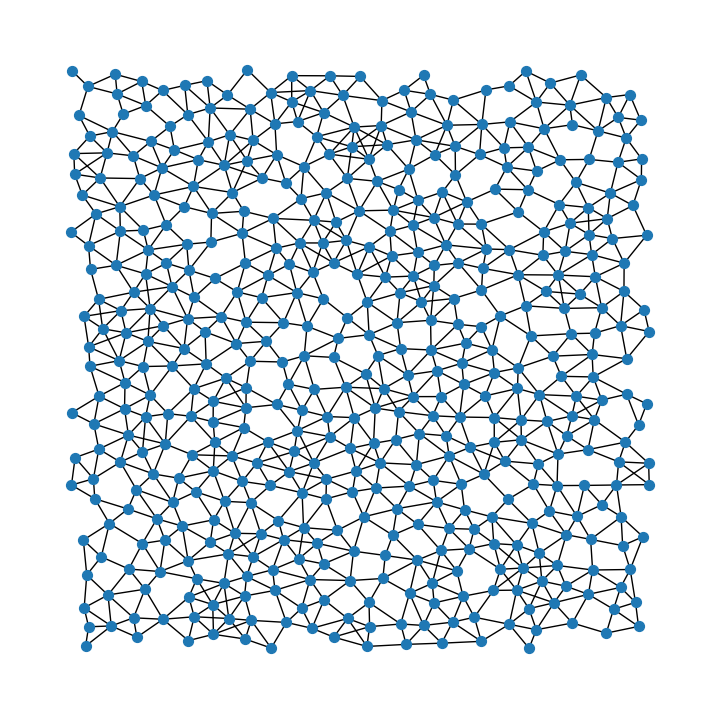

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
print("####################")
print("## dataset_sample ##")
print("####################")
# print("Shape:", dataset_sample.shape)
print("Length:", len(dataset_sample))
print("Type:", type(dataset_sample))
print(dataset_sample)
print("")

graph, position = dataset_sample[0]
print("###########")
print("## graph ##")
print("###########")
# print("Shape:", graph.shape)
print("Length:", len(graph))
print("Type:", type(graph))
print(graph)
print("")

print("##############")
print("## position ##")
print("##############")
print("Shape:", position.shape)
print("Length:", len(position))
print("Type:", type(position))
print(position)
print("")

print(f"first item in valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents type of node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents positions and velocities of particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents relative distance and displacement between particles.")
print(f"model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents acceleration of particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
print("##############")
print("## nx_graph ##")
print("##############")
# print("Shape:", nx_graph.shape)
print("Length:", len(nx_graph))
print("Type:", type(nx_graph))
print(nx_graph)
print("")


# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
print("##############")
print("## nx_graph ##")
print("##############")
# print("Shape:", nx_graph.shape)
print("Length:", len(nx_graph))
print("Type:", type(nx_graph))
print(nx_graph)
print("")


plt.figure(figsize=(7, 7))


nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)


plt.show()

## GNN Model

We will walk through implementation of GNN model in this section!

### Helper class

• first define a class for Multi-Layer Perceptron (MLP). 

• This class generates an MLP given width and depth of it. 

• Because MLPs are used in several places of GNN, this helper class will make code cleaner.

In [10]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        print("###############################")
        print("## self.layers ## MLP\_init_ ##")
        print("###############################")
        # print("Shape:", self.layers.shape)
        print("Length:", len(self.layers))
        print("Type:", type(self.layers))
        print(self.layers)
        print("")
        
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            
            
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
                print("#################################")
                print("## self.layers ## MLP\_init_\i ##")
                print("#################################")
                # print("Shape:", self.layers.shape)
                print("Length:", len(self.layers))
                print("Type:", type(self.layers))
                print(self.layers)
                print("")
                
                
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
            print("########################")
            print("## self.layers ## MLP ##")
            print("########################")
            # print("Shape:", self.layers.shape)
            print("Length:", len(self.layers))
            print("Type:", type(self.layers))
            print(self.layers)
            print("")
            
            
        self.reset_parameters()

    def reset_parameters(self):
        
        
        for layer in self.layers:
            print("###################################")
            print("## layer ## MLP\reset_parameters ##")
            print("###################################")
            # print("Shape:", layer.shape)
            # print("Length:", len(layer))
            print("Type:", type(layer))
            print(layer)
            print("")
            
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                print("###################################")
                print("## layer ## MLP\reset_parameters ##")
                print("###################################")
                # print("Shape:", layer.shape)
                # print("Length:", len(layer))
                print("Type:", type(layer))
                print(layer)
                print("")
                
                
                layer.bias.data.fill_(0)
                print("###################################")
                print("## layer ## MLP\reset_parameters ##")
                print("###################################")
                # print("Shape:", layer.shape)
                # print("Length:", len(layer))
                print("Type:", type(layer))
                print(layer)
                print("")

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### GNN layers

In following code block, we implement one type of GNN layer named `InteractionNetwork` (IN), which is proposed by paper *Interaction Networks for Learning about Objects,
Relations and Physics*.

• For a graph $G$, let feature of node $i$ be $v_i$, feature of edge $(i, j)$ be $e_{i, j}$. 

• three stages for IN to generate new features of nodes and edges.

1. **Message generation.**

• If there is an edge pointing from node $i$ to node $j$, node $i$ sends a message to node $j$. 

• message carries information of edge and its two nodes, so it is generated by following equation $\mathrm{Msg}_{i,j} = \mathrm{MLP}(v_i, v_j, e_{i,j})$.

2. **Message aggregation.**

• In this stage, each node of graph aggregates all messages it received to a fixed-sized representation. 

• In IN, aggregation means summing all messages up, i.e., $\mathrm{Agg}_i=\sum_{(j,i)\in G}\mathrm{Msg}_{i,j}$.

3. **Update.**

• update features of nodes and edges with results of previous stages. 

• For each edge, its new feature is sum of its old feature and correspond message, i.e., $e'_{i,j}=e_{i,j}+\mathrm{Msg}_{i,j}$. 

• For each node, new feature is determined by its old feature and aggregated message, i.e., $v'_i=v_i+\mathrm{MLP}(v_i, \mathrm{Agg}_i)$.

• In PyG, GNN layers are implemented as subclass of `MessagePassing`. 

• must override three critical functions to implement `InteractionNetwork` GNN layer. 

• Each function corresponds to one stage of GNN layer.

1. `message()` -> message generation

• This function controls how a message is generated on each edge of graph. 

• It takes three arguments:

• (1) `x_i`, features of source nodes; 

• (2) `x_j`, features of target nodes; 

• (3) `edge_feature`, features of edges themselves. 

• In IN, concatenate all these features and generate messages with an MLP.

1. `aggregate()` -> message aggregation

• This function aggregates messages for nodes. 

• It depends on two arguments:

• (1) `inputs`, messages; 

• (2) `index`, graph structure. 

• handle over task of message aggregation to function `torch_scatter.scatter` and specifies in argument `reduce` that want to sum messages up. 

• Because want to retain messages themselves to update edge features, return both messages and aggregated messages.

1. `forward()` -> update

• This function puts everything together. 

• `x` is node features, `edge_index` is graph structure and `edge_feature` is edge features. 

• function`MessagePassing.propagate` invokes functions `message` and `aggregate` for us. 

• Then, update node features and edge features and return them.

In [11]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        print("############################################")
        print("## edge_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", edge_out.shape)
        print("Length:", len(edge_out))
        print("Type:", type(edge_out))
        print(edge_out)
        print("")
        
        
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        print("############################################")
        print("## node_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", node_out.shape)
        print("Length:", len(node_out))
        print("Type:", type(node_out))
        print(node_out)
        print("")
        
        
        edge_out = edge_feature + edge_out
        print("############################################")
        print("## edge_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", edge_out.shape)
        print("Length:", len(edge_out))
        print("Type:", type(edge_out))
        print(edge_out)
        print("")
        
        
        node_out = x + node_out
        print("############################################")
        print("## node_out ## InteractionNetwork\forward ##")
        print("############################################")
        print("Shape:", node_out.shape)
        print("Length:", len(node_out))
        print("Type:", type(node_out))
        print(node_out)
        print("")
        
        
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        print("#####################################")
        print("## x ## InteractionNetwork\message ##")
        print("#####################################")
        print("Shape:", x.shape)
        print("Length:", len(x))
        print("Type:", type(x))
        print(x)
        print("")
        
        
        x = self.lin_edge(x)
        print("#####################################")
        print("## x ## InteractionNetwork\message ##")
        print("#####################################")
        print("Shape:", x.shape)
        print("Length:", len(x))
        print("Type:", type(x))
        print(x)
        print("")
        
        
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        print("#########################################")
        print("## out ## InteractionNetwork\aggregate ##")
        print("#########################################")
        print("Shape:", out.shape)
        print("Length:", len(out))
        print("Type:", type(out))
        print(out)
        print("")
        
        return (inputs, out)

### GNN

• Now its time to stack GNN layers to a GNN. 

• Besides GNN layers, pre-processing and post-processing blocks in GNN. 

• Before GNN layers, input features are transformed by MLP so expressiveness of GNN is improved without increasing GNN layers. 

• After GNN layers, final outputs (accelerations of particles in case) are extracted from features generated by GNN layers to meet requirement of task.

In [12]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of world, typical 2D or 3D
        window_size=5, # model looks into W frames before frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        print("############################################")
        print("## window_size ## LearnedSimulator\_init_ ##")
        print("############################################")
        print(window_size)
        print("")
        
        
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        print("#####################")
        print("## self.embed_type ## LearnedSimulator\_init_ ##")
        print("#####################")
        # print("Shape:", self.embed_type.shape)
        # print("Length:", len(self.embed_type))
        print("Type:", type(self.embed_type))
        print(self.embed_type)
        print("")
        
        
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        print("#############################################")
        print("## self.node_in ## LearnedSimulator\_init_ ##")
        print("#############################################")
        # print("Shape:", self.node_in.shape)
        # print("Length:", len(self.node_in))
        print("Type:", type(self.node_in))
        print(self.node_in)
        print("")
        
        
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        print("#############################################")
        print("## self.edge_in ## LearnedSimulator\_init_ ##")
        print("#############################################")
        # print("Shape:", self.edge_in.shape)
        # print("Length:", len(self.edge_in))
        print("Type:", type(self.edge_in))
        print(self.edge_in)
        print("")
        
        
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        print("##############################################")
        print("## self.node_out ## LearnedSimulator\_init_ ##")
        print("##############################################")
        # print("Shape:", self.node_out.shape)
        # print("Length:", len(self.node_out))
        print("Type:", type(self.node_out))
        print(self.node_out)
        print("")
        
        
        self.n_mp_layers = n_mp_layers
        print("############################################")
        print("## n_mp_layers ## LearnedSimulator\_init_ ##")
        print("############################################")
        # print("Shape:", n_mp_layers.shape)
        # print("Length:", len(n_mp_layers))
        print("Type:", type(n_mp_layers))
        print(n_mp_layers)
        print("")
        
        
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        print("##############################################")
        print("## node_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", node_feature.shape)
        print("Length:", len(node_feature))
        print("Type:", type(node_feature))
        print(node_feature)
        print("")
        
        
        node_feature = self.node_in(node_feature)
        print("##############################################")
        print("## node_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", node_feature.shape)
        print("Length:", len(node_feature))
        print("Type:", type(node_feature))
        print(node_feature)
        print("")
        
        
        edge_feature = self.edge_in(data.edge_attr)
        print("##############################################")
        print("## edge_feature ## LearnedSimulator\forward ##")
        print("##############################################")
        print("Shape:", edge_feature.shape)
        print("Length:", len(edge_feature))
        print("Type:", type(edge_feature))
        print(edge_feature)
        print("")
        
        
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
            print("################################################")
            print("## node_feature ## LearnedSimulator\forward\i ##")
            print("################################################")
            print("Shape:", node_feature.shape)
            print("Length:", len(node_feature))
            print("Type:", type(node_feature))
            print(node_feature)
            print("")
            print("")            
            print("################################################")
            print("## edge_feature ## LearnedSimulator\forward\i ##")
            print("################################################")
            print("Shape:", edge_feature.shape)
            print("Length:", len(edge_feature))
            print("Type:", type(edge_feature))
            print(edge_feature)
            print("")
            
            
        # post-processing
        out = self.node_out(node_feature)
        
        
        return out

## Training

• Before start training model, let's configure hyperparameters! 

• Since accessible computaion power is limited in Colab, will only run 1 epoch of training, which takes about 1.5 hour. 

• won't produce as accurate results as shown in original paper in this Colab. 

• provide a checkpoint of training model on entire WaterDrop dataset for 5 epochs, which takes about 14 hours with a GeForce RTX 3080 Ti.

In [13]:
data_path = OUTPUT_DIR
print("###############")
print("## data_path ##")
print("###############")
print(data_path)
print("")


model_path = os.path.join("temp", "models", DATASET_NAME)
print("################")
print("## model_path ##")
print("################")
print(model_path)
print("")


rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)
print("##################")
print("## rollout_path ##")
print("##################")
print(rollout_path)
print("")


!mkdir -p "$model_path"
!mkdir -p "$rollout_path"

params = {
    #"epoch": 1,
    "epoch": 20,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 1000,
    "eval_interval": 1000,
    "rollout_interval": 200000,
}

###############
## data_path ##
###############
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

################
## model_path ##
################
temp/models/WaterDrop

##################
## rollout_path ##
##################
temp/rollouts/WaterDrop



Below are some helper functions for evaluation.

In [14]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    print("#######################")
    print("## device ## rollout ##")
    print("#######################")
    print(device)
    print("")
    
    
    model.eval()
    
    
    window_size = model.window_size + 1
    print("############################")
    print("## window_size ## rollout ##")
    print("############################")
    print(window_size)
    print("")

    
    total_time = data["position"].size(0)
    print("###########################")
    print("## total_time ## rollout ##")
    print("###########################")
    print(total_time)
    print("")
    
    
    traj = data["position"][:window_size]
    print("#####################")
    print("## traj ## rollout ##")
    print("#####################")
    print(traj)
    print("")
    
    
    traj = traj.permute(1, 0, 2)
    print("#####################")
    print("## traj ## rollout ##")
    print("#####################")
    print(traj)
    print("")
    
    
    particle_type = data["particle_type"]
    print("##############################")
    print("## particle_type ## rollout ##")
    print("##############################")
    print(particle_type)
    print("")
    
    

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            print("###########################")
            print("## graph ## rollout\time ##")
            print("###########################")
            print(graph)
            print("")
            
            
            graph = graph.to(device)
            print("###########################")
            print("## graph ## rollout\time ##")
            print("###########################")
            print(graph)
            print("")
            
            
            acceleration = model(graph).cpu()
            print("##################################")
            print("## acceleration ## rollout\time ##")
            print("##################################")
            print(acceleration)
            print("")
            
            
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])
            print("##################################")
            print("## acceleration ## rollout\time ##")
            print("##################################")
            print(acceleration)
            print("")
                        

            recent_position = traj[:, -1]
            print("#####################################")
            print("## recent_position ## rollout\time ##")
            print("#####################################")
            print(recent_position)
            print("")
            
            
            recent_velocity = recent_position - traj[:, -2]
            print("#####################################")
            print("## recent_velocity ## rollout\time ##")
            print("#####################################")
            print(recent_velocity)
            print("")
            
            
            new_velocity = recent_velocity + acceleration
            print("##################################")
            print("## new_velocity ## rollout\time ##")
            print("##################################")
            print(new_velocity)
            print("")
            
            
            new_position = recent_position + new_velocity
            print("##################################")
            print("## new_position ## rollout\time ##")
            print("##################################")
            print(new_position)
            print("")
            
            
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)
            print("##########################")
            print("## traj ## rollout\time ##")
            print("##########################")
            print(traj)
            print("")
            

    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.cuda()
            print("#############################")
            print("## data ## oneStepMSE\data ##")
            print("#############################")
            print(data)
            print("")
            
            
            pred = simulator(data)
            print("#############################")
            print("## pred ## oneStepMSE\data ##")
            print("#############################")
            print(pred)
            print("")
            
            
            mse = ((pred - data.y) * scale) ** 2
            print("############################")
            print("## mse ## oneStepMSE\data ##")
            print("############################")
            print(mse)
            print("")
            
            
            mse = mse.sum(dim=-1).mean()
            print("############################")
            print("## mse ## oneStepMSE\data ##")
            print("############################")
            print(mse)
            print("")
            
            
            loss = ((pred - data.y) ** 2).mean()
            print("#############################")
            print("## loss ## oneStepMSE\data ##")
            print("#############################")
            print(loss)
            print("")
            
            
            total_mse += mse.item()
            print("##################################")
            print("## total_mse ## oneStepMSE\data ##")
            print("##################################")
            print(total_mse)
            print("")
            
            
            total_loss += loss.item()
            print("###################################")
            print("## total_loss ## oneStepMSE\data ##")
            print("###################################")
            print(total_loss)
            print("")
           
            
            batch_count += 1
            print("####################################")
            print("## batch_count ## oneStepMSE\data ##")
            print("####################################")
            print(batch_count)
            print("")
            
            
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            print("#############################################")
            print("## rollout_data ## rolloutMSE\rollout_data ##")
            print("#############################################")
            print("Shape:", rollout_data.shape)
            print("Length:", len(rollout_data))
            print("Type:", type(rollout_data))
            print(rollout_data)
            print("")
            
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            print("############################################")
            print("## rollout_out ## rolloutMSE\rollout_data ##")
            print("############################################")
            print("Shape:", rollout_out.shape)
            print("Length:", len(rollout_out))
            print("Type:", type(rollout_out))
            print(rollout_out)
            print("")
            
            
            rollout_out = rollout_out.permute(1, 0, 2)
            print("############################################")
            print("## rollout_out ## rolloutMSE\rollout_data ##")
            print("############################################")
            print("Shape:", rollout_out.shape)
            print("Length:", len(rollout_out))
            print("Type:", type(rollout_out))
            print(rollout_out)
            print("")
            
            
            loss = (rollout_out - rollout_data["position"]) ** 2
            print("#####################################")
            print("## loss ## rolloutMSE\rollout_data ##")
            print("#####################################")
            print(loss)
            print("")
            
            
            loss = loss.sum(dim=-1).mean()
            print("#####################################")
            print("## loss ## rolloutMSE\rollout_data ##")
            print("#####################################")
            print(loss)
            print("")
            
            
            total_loss += loss.item()
            print("###########################################")
            print("## total_loss ## rolloutMSE\rollout_data ##")
            print("###########################################")
            print(total_loss)
            print("")
            
            
            batch_count += 1
            print("############################################")
            print("## batch_count ## rolloutMSE\rollout_data ##")
            print("############################################")
            print(batch_count)
            print("")
            
            
    return total_loss / batch_count

Here is main training loop!

In [15]:
from tqdm import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    print("######################")
    print("## loss_fn ## train ##")
    print("######################")
    # print("Shape:", loss_fn.shape)
    # print("Length:", len(loss_fn))
    print("Type:", type(loss_fn))
    print(loss_fn)
    print("")
    
    
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    print("########################")
    print("## optimizer ## train ##")
    print("########################")
    # print("Shape:", optimizer.shape)
    # print("Length:", len(optimizer))
    print("Type:", type(optimizer))
    print(optimizer)
    print("")
    
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
    print("########################")
    print("## scheduler ## train ##")
    print("########################")
    # print("Shape:", scheduler.shape)
    # print("Length:", len(scheduler))
    print("Type:", type(scheduler))
    print(scheduler)
    print("")
    
    

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        print("#############################")
        print("## progress_bar ## train\i ##")
        print("#############################")
        print(progress_bar)
        print("")
        
        
        total_loss = 0
        print("###########################")
        print("## total_loss ## train\i ##")
        print("###########################")
        print(total_loss)
        print("")
        
        
        batch_count = 0
        print("############################")
        print("## batch_count ## train\i ##")
        print("############################")
        print(batch_count)
        print("")
        
        
        
        for data in progress_bar:
            optimizer.zero_grad()
            print("###############################")
            print("## optimizer ## train\i\data ##")
            print("###############################")
            # print("Shape:", optimizer.shape)
            # print("Length:", len(optimizer))
            print("Type:", type(optimizer))
            print(optimizer)
            print("")
            
            
            data = data.cuda()
            print("##########################")
            print("## data ## train\i\data ##")
            print("##########################")
            # print("Shape:", data.shape)
            print("Length:", len(data))
            print("Type:", type(data))
            print(data)
            print("")
            
            
            pred = simulator(data)
            print("##########################")
            print("## pred ## train\i\data ##")
            print("##########################")
            print("Shape:", pred.shape)
            print("Length:", len(pred))
            print("Type:", type(pred))
            print(pred)
            print("")
            
            
            loss = loss_fn(pred, data.y)
            print("##########")
            print("## loss ## train\i\data ##")
            print("##########")
            print("Shape:", loss.shape)
            # print("Length:", len(loss))
            print("Type:", type(loss))
            print(loss)
            print("")
            
            
            loss.backward()


            optimizer.step()


            scheduler.step()


            total_loss += loss.item()
            print("################")
            print("## total_loss ## train\i\data ##")
            print("################")
            print(total_loss)
            print("")


            batch_count += 1
            print("#################################")
            print("## batch_count ## train\i\data ##")
            print("#################################")
            print(batch_count)
            print("")


            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})


            total_step += 1
            print("################################")
            print("## total_step ## train\i\data ##")
            print("################################")
            print(total_step)
            print("")


            train_loss_list.append((total_step, loss.item()))
            print("#####################################")
            print("## train_loss_list ## train\i\data ##")
            print("#####################################")
            # print("Shape:", train_loss_list.shape)
            print("Length:", len(train_loss_list))
            print("Type:", type(train_loss_list))
            print(train_loss_list)
            print("")



            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                print("###############################")
                print("## eval_loss ## train\i\data ##")
                print("###############################")
                print("Shape:", eval_loss.shape)
                print("Length:", len(eval_loss))
                print("Type:", type(eval_loss))
                print(eval_loss)
                print("")


                eval_loss_list.append((total_step, eval_loss))
                print("####################################")
                print("## eval_loss_list ## train\i\data ##")
                print("####################################")
                print("Shape:", eval_loss_list.shape)
                print("Length:", len(eval_loss_list))
                print("Type:", type(eval_loss_list))
                print(eval_loss_list)
                print("")


                onestep_mse_list.append((total_step, onestep_mse))
                print("######################################")
                print("## onestep_mse_list ## train\i\data ##")
                print("######################################")
                print("Shape:", onestep_mse_list.shape)
                print("Length:", len(onestep_mse_list))
                print("Type:", type(onestep_mse_list))
                print(onestep_mse_list)
                print("")



                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                print("#################################")
                print("## rollout_mse ## train\i\data ##")
                print("#################################")
                print(rollout_mse)
                print("")


                rollout_mse_list.append((total_step, rollout_mse))
                print("######################################")
                print("## rollout_mse_list ## train\i\data ##")
                print("######################################")
                print(rollout_mse_list)
                print("")


                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                print("################################")
                print("## total_step ## train\i\data ##")
                print("################################")
                print(total_step)
                print("")

                print("###########################################")
                print("## params[save_interval] ## train\i\data ##")
                print("###########################################")
                print(params["save_interval"])
                print("")

                
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

• let's load dataset and train model! 

• It takes roughly 1.5 hour to run this block on Colab with default parameters. 

• **If you are impatient, highly recommend you to skip next 2 blocks and load checkpoint provided to save some time;**

• **otherwise, make a cup of tea/coffee and come back later to see results of training!**

In [16]:
# Training model is time-consuming. We highly recommend you to skip this block and load checkpoint in next block.

# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
print("###################")
print("## train_dataset ##")
print("###################")
# print("Shape:", train_dataset.shape)
print("Length:", len(train_dataset))
print("Type:", type(train_dataset))
print(train_dataset)
print("")



valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
print("###################")
print("## valid_dataset ##")
print("###################")
# print("Shape:", valid_dataset.shape)
print("Length:", len(valid_dataset))
print("Type:", type(valid_dataset))
print(valid_dataset)
print("")



train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
print("##################")
print("## train_loader ##")
print("##################")
# print("Shape:", train_loader.shape)
print("Length:", len(train_loader))
print("Type:", type(train_loader))
print(train_loader)
print("")



valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
print("##################")
print("## valid_loader ##")
print("##################")
# print("Shape:", valid_loader.shape)
print("Length:", len(valid_loader))
print("Type:", type(valid_loader))
print(valid_loader)
print("")



valid_rollout_dataset = RolloutDataset(data_path, "valid")
print("###########################")
print("## valid_rollout_dataset ##")
print("###########################")
# print("Shape:", valid_rollout_dataset.shape)
print("Length:", len(valid_rollout_dataset))
print("Type:", type(valid_rollout_dataset))
print(valid_rollout_dataset)
print("")




# build model
simulator = LearnedSimulator()


simulator = simulator.cuda()



# train model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)



#################################
## data_path ## OneStepDataset ##
#################################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

#####################################
## self.metadata ## OneStepDataset ##
#####################################
Length: 9
Type: <class 'dict'>
{'bounds': [[0.1, 0.9], [0.1, 0.9]], 'sequence_length': 1000, 'default_connectivity_radius': 0.015, 'dim': 2, 'dt': 0.0025, 'vel_mean': [-3.964619574176163e-05, -0.00026272129664401046], 'vel_std': [0.0013722809722366911, 0.0013119977252142715], 'acc_mean': [2.602686518497945e-08, 1.0721623948191945e-07], 'acc_std': [6.742962470925277e-05, 8.700719180424815e-05]}

###################################
## self.offset ## OneStepDataset ## 1
###################################
Length: 100
Type: <class 'dict'>
{'0': {'particle_type': {'offset': 0, 'shape': [678]}, 'position': {'offset': 0, 'shape': [1001, 678, 2]}}, '1': {'particle_type': {'offset': 678, 'shape': [355]}, 'position': {'offset': 1357

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# Save trained model
model_save_path = "simulator_model_20epoch.pth"


torch.save(simulator.state_dict(), model_save_path)


print(f"Model saved to {model_save_path}")

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

NameError: name 'train_loss_list' is not defined

<Figure size 640x480 with 0 Axes>

• Load checkpoint trained by us. 

• Do **not** run this block if you have trained your model in previous block.

In [ ]:
################
## LOAD MODEL ##
################
simulator = LearnedSimulator()


simulator = simulator.cuda()


#!wget -O temp/models/WaterDrop_checkpoint.pt https://storage.googleapis.com/cs224w_course_project_dataset/Checkpoints/WaterDrop_checkpoint.pt
# checkpoint = torch.load("simulator_model_20epoch.pth")
# simulator.load_state_dict(checkpoint["model"])
model_save_path = "simulator_model_20epoch.pth"


simulator.load_state_dict(torch.load(model_save_path))

## Visualization

Since video is 1000 frames long, it might take a few minutes to rollout.

In [ ]:
rollout_dataset = RolloutDataset(data_path, "valid")


simulator.eval()


rollout_data = rollout_dataset[0]


rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])


rollout_out = rollout_out.permute(1, 0, 2)



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []


        for _, position, points in plot_info:


            for type_, line in points.items():
                mask = particle_type == type_


                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])


            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

## Conclusion

• Hope this Colab is helpful for you to understand how to apply GNN in a real-world application like simulating complex physics! 

• If you're interested in technical details, read [medium post](https://) or see [original paper](https://arxiv.org/abs/2002.09405) by DeepMind. 

• Thanks for spending your time with us!